In [102]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import confusion_matrix

In [103]:
df = pd.read_csv(r'doc_without_judge_missing.csv')

In [104]:
df.columns

Index(['File', 'years_from_trial', 'days_jail_doc',
       'County of Commitment_ALBANY ', 'County of Commitment_ALLEGANY ',
       'County of Commitment_BRONX ', 'County of Commitment_BROOME ',
       'County of Commitment_CATTARAUGUS ', 'County of Commitment_CAYUGA ',
       'County of Commitment_CHAUTAUQUA ',
       ...
       'type_crime_welfare fraud', 'type_crime_nan', 'degree_crime_fifth',
       'degree_crime_first', 'degree_crime_fourth', 'degree_crime_second',
       'degree_crime_seventh', 'degree_crime_sixth', 'degree_crime_third',
       'degree_crime_nan'],
      dtype='object', length=415)

In [105]:
del df['File']

In [106]:
del df['nycourts']
del df['CC']
del df['SC-AJ']

In [113]:
1- len(np.where(df['Y'] == 1)[0])/len(df)

0.8407917383820999

In [79]:
y = df['Y']
X = df.loc[:, df.columns != 'Y']

In [51]:
normalized_X = preprocessing.normalize(X)
X_Normalized = pd.DataFrame(normalized_X, columns = X.columns)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_Normalized, y, test_size=0.3,random_state=42)

    Baseline KNN Model

In [53]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)
# fitting the model
knn.fit(X_train, y_train)
# predict the response
pred = knn.predict(X_test)
# evaluate accuracy
print (accuracy_score(y_test, pred))

0.835243553009


In [54]:
# creating odd list of K for KNN
myList = list(range(1,70))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

In [55]:
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print("optimal k : %s" % optimal_k)

optimal k : 19


In [56]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=optimal_k)
# fitting the model
knn.fit(X_train, y_train)
# predict the response
pred = knn.predict(X_test)
# evaluate accuracy

In [68]:
print("Accuracy: %s" % (accuracy_score(y_test, pred)))
cm = confusion_matrix(pred,y_test)
print(cm)

Accuracy: 0.852435530086
[[593 103]
 [  0   2]]


    Understand features

In [58]:
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

In [59]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20)
dt.fit(X_train, y_train)

#Now use built in feature importance attribute to get MI of each feature and Y
feature_mi = dt.feature_importances_
feature_mi_dict = dict(zip(X_train.columns.values, feature_mi))


In [60]:
def FeatureROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc

In [61]:
feature_auc_dict = {}
for col in X_train.columns:
    feature_auc_dict[col] = FeatureROC(X_train[col], y_train, col)

In [62]:
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_mi = pd.DataFrame(pd.Series(feature_mi_dict), columns = ['mi'])

#Now merge the two on the feature name
feat_imp_df = df_auc.merge(df_mi, left_index = True, right_index = True)

In [63]:
feat_ranks = feat_imp_df.rank(axis = 0, ascending = False)
#Now create lists of top 5 features for both auc and mi
top5_auc = list(feat_ranks[(feat_ranks.auc <= 10)].index.values)
top5_mi = list(feat_ranks[(feat_ranks.mi <= 10)].index.values)
top5_auc, top5_mi

(['County of Commitment_NEW YORK ',
  'Gap_days',
  'Race/Ethnicity_WHITE ',
  'Unanimous',
  'a_Thursday',
  'a_Tuesday',
  'days_jail_doc',
  'f_Friday',
  'start year',
  'unanimous'],
 ['AppealD_month_x',
  'AppealD_month_y',
  'County of Commitment_QUEENS ',
  'FirstD_2014.0',
  'FirstD_month_x',
  'FirstD_month_y',
  'Gap_days',
  'Sex_MALE ',
  'days_jail_doc',
  'years_from_trial'])

In [69]:
for weights in ['uniform', 'distance']:
    clf = KNeighborsClassifier(n_neighbors=optimal_k, weights=weights)
    clf.fit(X, y)
    pred = clf.predict(X_test)
    print("Accuracy for %s: %s" % (weights,accuracy_score(y_test, pred)))
 

Accuracy for uniform: 0.849570200573
Accuracy for distance: 0.849570200573


In [98]:
X_train_2D = X_train[['days_jail_doc','Gap_days']]

In [99]:
clf = KNeighborsClassifier(n_neighbors=optimal_k)
clf.fit(X_train_2D, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform')

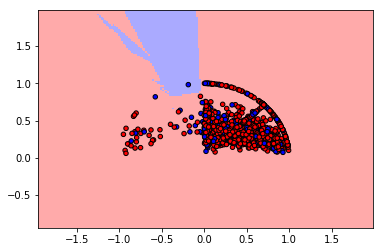

In [101]:
from matplotlib.colors import ListedColormap
h = .02
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = X_train_2D.iloc[:, 0].min() - 1, X_train_2D.iloc[:, 0].max() + 1
y_min, y_max = X_train_2D.iloc[:, 1].min() - 1, X_train_2D.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_train_2D.iloc[:, 0], X_train_2D.iloc[:, 1], c=y_train, cmap=cmap_bold,edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()